In [36]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import csv
import keras
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from keras.layers import Dense, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU

In [37]:
with open("0700.HK.csv") as csv_file: ### Modify this part to try different stocks
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader)
    open_price = []
    close_price = []
    high_price = []
    low_price = []
    volume = []
    ma_15days = []
    rsi = []
    daily_return = []
    macd = []
    signal = []
    for row in csv_reader:
        open_price.append(row[3])
        close_price.append(row[2])
        high_price.append(row[4])
        low_price.append(row[5])
        volume.append(row[7])
        daily_return.append(row[9])
        ma_15days.append(row[16])
        rsi.append(row[17])
        macd.append(row[24])
        signal.append(row[25])
    daily_return[0] = 0
    for i in range(15):
        ma_15days[i] = 0
        rsi[i] = 0
    for i in range(25):
        macd[i] = 0
    for i in range(33):
        signal[i] = 0
    for i in range(len(open_price)):
        open_price[i] = float(open_price[i])
        close_price[i] = float(close_price[i])
        high_price[i] = float(high_price[i])
        low_price[i] = float(low_price[i])
        volume[i] = float(volume[i])
        daily_return[i] = float(daily_return[i])
        ma_15days[i] = float(ma_15days[i])
        rsi[i] = float(rsi[i])
        macd[i] = float(macd[i])
        signal[i] = float(signal[i])

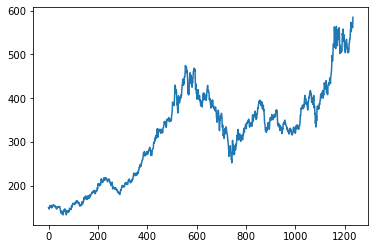

In [38]:
plt.plot(close_price)

In [39]:
return_level = []
for i in range(36,401):
    if daily_return[i] >= 0:
        return_level.append(1)
    elif daily_return[i] <0:
        return_level.append(0)

In [40]:
training_sets = []
training_label = []
Close = [[], [], [], [], []] #5 lists for 5 days closing prices
MA15 = [[], [], [], [], []]
RSI = [[], [], [], [], []]
Vol = [[], [], [], [], []]
MACD = [[], [], [], [], []]
Sig = [[], [], [], [], []]
for i in range(len(return_level)):
    training_label.append(return_level[i])
for i in range(35, 400):
    for j in range(5):
        #Open.append(open_price[i+j-4])
        Close[j].append(float(close_price[i+j-4]))
        #High_list.append(high_price[i+j-4])
        #_list.append(low_price[i+j-4])
        MA15[j].append(float(ma_15days[i+j-4]))
        RSI[j].append(float(rsi[i+j-4]))
        Vol[j].append(float(volume[i+j-4]))
        MACD[j].append(float(macd[i+j-4]))
        Sig[j].append(float(signal[i+j-4]))
for j in range(5):
    training_sets.append(Close[j])
    training_sets.append(MA15[j])
    training_sets.append(RSI[j])
    training_sets.append(Vol[j])
    training_sets.append(MACD[j])
    training_sets.append(Sig[j])
    #print(Close[2])
training_sets = np.array(training_sets)
training_label = np.array(training_label)

In [41]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [42]:
def layer_sizes(X,Y):
    n_x = X.shape[0]
    n_h = 5 # it is the number of neurons in the hidden unit
    n_y = Y.shape[0]
    return (n_x,n_h,n_y)

In [43]:
def initialize_parameters(n_x,n_h,n_y):
    np.random.seed(1)
    W1 = np.random.randn(n_h,n_x)*0.01
    W2 = np.random.randn(n_y,n_h)
    b1 = np.zeros((n_h,1))
    b2 = np.zeros((n_y,1))
    parameters = { "W1": W1,"W2": W2,"b1": b1,"b2": b2 }
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    return parameters

In [44]:
def forward_propagation(X,parameters):
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    b1 = parameters["b1"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1,X)+b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1)+b2
    #Z2 = np.sum(Z2,axis=0,keepdims=True)
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1":Z1, "Z2":Z2, "A1":A1, "A2":A2}
    return A2, cache

In [45]:
def cost(A2, Y, parameters):
    #compute cost using cross-entropy
    m = Y.shape[1]
    logprobs = np.multiply(np.log(A2),Y)+np.multiply(np.log(1-A2),1-Y)
    cost = -1/m*np.sum(logprobs)
    cost = float(np.squeeze(cost))
    
    return cost

In [46]:
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    dZ2 = A2 - Y
    dW2 = 1/m*np.dot(dZ2,A1.T)
    db2 = 1/m*np.sum(dZ2, axis=1, keepdims = True)
    dZ1 = np.dot(W2.T,dZ2)*(1-np.power(A1,2))
    dW1 = 1/m*np.dot(dZ1,X.T)
    db1 = 1/m*np.sum(dZ1, axis=1, keepdims=True)
    grads = {"dW1":dW1, "db1":db1, "dW2":dW2, "db2":db2}
    
    return grads

In [47]:
def update_parameters(parameters, grads, learning_rate = 0.01):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    
    return parameters

In [48]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):    
    np.random.seed(1)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    parameters = initialize_parameters(n_x,n_h,n_y)
    
    for i in range(0, num_iterations):
        A2, cache = forward_propagation(X, parameters)
        costs = cost(A2, Y, parameters)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads, learning_rate = 0.0008)
        
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, costs))
    return parameters

In [49]:
training_label.shape = [training_label.shape[0],1]
parameters = nn_model(training_sets, training_label.T, 5, num_iterations=200000, print_cost=True)
training_label.shape

Cost after iteration 0: 1.193943
Cost after iteration 1000: 1.076587
Cost after iteration 2000: 1.010674
Cost after iteration 3000: 0.959623
Cost after iteration 4000: 0.915508
Cost after iteration 5000: 0.876639
Cost after iteration 6000: 0.842763
Cost after iteration 7000: 0.813842
Cost after iteration 8000: 0.789713
Cost after iteration 9000: 0.770020
Cost after iteration 10000: 0.754254
Cost after iteration 11000: 0.741831
Cost after iteration 12000: 0.732157
Cost after iteration 13000: 0.724683
Cost after iteration 14000: 0.718931
Cost after iteration 15000: 0.714501
Cost after iteration 16000: 0.711074
Cost after iteration 17000: 0.708399
Cost after iteration 18000: 0.706281
Cost after iteration 19000: 0.704577
Cost after iteration 20000: 0.703175
Cost after iteration 21000: 0.701997
Cost after iteration 22000: 0.700982
Cost after iteration 23000: 0.700087
Cost after iteration 24000: 0.699280
Cost after iteration 25000: 0.698540
Cost after iteration 26000: 0.697850
Cost after ite

(365, 1)

In [50]:
def predict(parameters, X):
    A2, cache = forward_propagation(X, parameters)
    predictions = 0+(A2>0.5)
    return predictions

In [51]:
predictions = predict(parameters, training_sets)
#print ('Accuracy: %d' % np.sum((np.dot(training_label,predictions) + np.dot(1-training_label,1-predictions))/float(training_label.size**2)*100) + '%')
predictions = predictions.tolist()
predictions = predictions[0]

In [52]:
principal = 1
for i in range(len(predictions)):
    if (predictions[i] == 1):
        principal = principal*(1+daily_return[35+i])
print("The return of the model on train set is: ",(principal-1)*100,"%")
principal

The return of the model on train set is:  13.38448317021792 %


1.1338448317021792

In [53]:
principal = 1
for i in range(len(predictions)):
    principal = principal*(1+daily_return[35+i])
print("The return of holding is: ",(principal-1)*100,"%")
principal

The return of holding is:  83.45763168745854 %


1.8345763168745854

In [54]:
test_sets = []
test_label = []
Close_t = [[], [], [], [], []] #5 lists for 5 days closing prices
MA15_t = [[], [], [], [], []]
RSI_t = [[], [], [], [], []]
Vol_t = [[], [], [], [], []]
MACD_t = [[], [], [], [], []]
Sig_t = [[], [], [], [], []]
for i in range(401, 601):
    for j in range(5):
        #Open.append(open_price[i+j-4])
        Close_t[j].append(float(close_price[i+j-4]))
        #High_list.append(high_price[i+j-4])
        #_list.append(low_price[i+j-4])
        MA15_t[j].append(float(ma_15days[i+j-4]))
        RSI_t[j].append(float(rsi[i+j-4]))
        Vol_t[j].append(float(volume[i+j-4]))
        MACD_t[j].append(float(macd[i+j-4]))
        Sig_t[j].append(float(signal[i+j-4]))
for j in range(5):
    test_sets.append(Close_t[j])
    test_sets.append(MA15_t[j])
    test_sets.append(RSI_t[j])
    test_sets.append(Vol_t[j])
    test_sets.append(MACD_t[j])
    test_sets.append(Sig_t[j])
test_sets = np.array(test_sets)
test_label = np.array(test_label)

In [55]:
predictions = predict(parameters, test_sets)
print ('Accuracy: %d' % np.sum((np.dot(training_label,predictions) + np.dot(1-training_label,1-predictions))/float(training_label.size**2)*100) + '%')
predictions = predictions.tolist()
predictions = predictions[0]

Accuracy: 28%


In [56]:
principal = 1
for i in range(len(predictions)):
    if (predictions[i] == 1):
        principal = principal*(1+daily_return[400+i])
print("The return of the model on test set is: ",(principal-1)*100,"%")
principal

The return of the model on test set is:  67.08994930368742 %


1.6708994930368741

In [57]:
for i in range(len(predictions)):
    principal = principal*(1+daily_return[400+i])
print("The return of holding is: ",(principal-1)*100,"%")

The return of holding is:  154.52504595074424 %
